In [10]:
import multiprocessing
from typing import Tuple
print(f'Number of cores: {multiprocessing.cpu_count()}')

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import seaborn as sns

Number of cores: 128


In [11]:
def random_cov(rng: np.random.Generator, eps: float = 1E-1) -> np.ndarray:
    C = rng.standard_normal((2, 2))
    C = C / np.linalg.norm(C, axis=0)
    C = C @ C.T + eps * np.eye(2)
    return C

def random_mean(rng: np.random.Generator) -> np.ndarray:
    mu = rng.standard_normal(2)
    mu = mu / np.linalg.norm(mu)
    return mu

def generate_data(n_conditions: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    C = [random_cov(rng) for _ in range(n_conditions)]
    mu = [random_mean(rng) for _ in range(n_conditions)]
    return mu, C

def generate_samples(mu: np.ndarray, C: np.ndarray, n_samples: int, rng: np.random.Generator) -> np.ndarray:
    N = len(mu)
    return rng.multivariate_normal(mu, C, size=(n_samples,)) 

# plot 2d ellipses representing the covariance matrices
def plot_cov_ellipse(cov: np.ndarray, mean: np.ndarray, stdev: float, ax, **kwargs) -> Ellipse:
    """Plot an ellipse with a given position and covariance"""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = stdev*np.sqrt(eigenvalues)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellipse)
    return ellipse

def plot_ellipses(cov: np.ndarray, mean: np.ndarray, stdevs=(0.5, 1., 2.), ax=None, **kwargs) -> None:
    if ax is None:
        ax = plt.gca()
    for stdev in stdevs:
        plot_cov_ellipse(cov, mean, stdev, ax=ax, **kwargs)

def rot2d(C: np.ndarray, theta: float) -> np.ndarray:
    R = np.array([[np.cos(theta), -np.sin(theta)], 
                  [np.sin(theta), np.cos(theta)]])
    return R.T@C@R

## Noise correlations

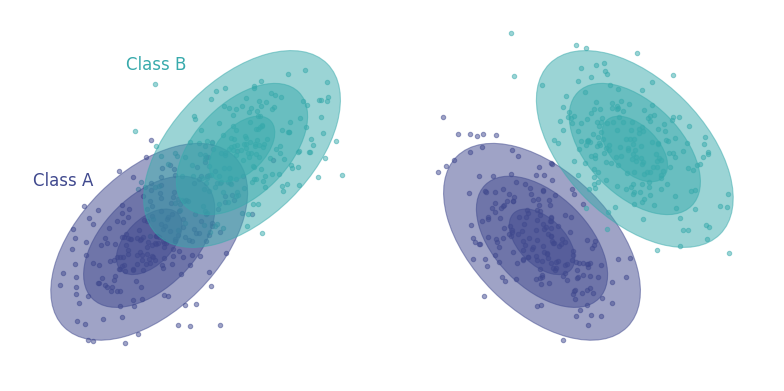

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex='all', sharey='all', dpi=100)

rng = np.random.default_rng(42069)
cols = sns.color_palette('mako', 2)
with sns.plotting_context('paper'):
    n_samples = 200
    C0 = rot2d(np.array([[3, 0], [0, 1]]), -np.pi/4)
    C1 = rot2d(np.array([[3, 0], [0, 1]]), np.pi/4)

    mu_a = np.array([-1, -1]) * .5
    mu_b = np.array([1,  1]) * .5

    ax[0].scatter(*generate_samples(mu_a, C0*.1, n_samples, rng).T, s=10, color=cols[0], alpha=0.5)
    ax[0].scatter(*generate_samples(mu_b, C0*.1, n_samples, rng).T, s=10, color=cols[1], alpha=0.5)
    plot_ellipses(C0, mu_a, stdevs=(.5, 1., 1.5), ax=ax[0], alpha=0.5, color=cols[0])
    plot_ellipses(C0, mu_b, stdevs=(.5, 1., 1.5), ax=ax[0], alpha=0.5, color=cols[1])


    # add text Class A and B
    ax[0].text(mu_a[0]-.6, mu_a[1]+.75, 'Class A', ha='right', va='top', color=cols[0], fontsize=12)
    ax[0].text(mu_b[0]-.6, mu_b[1]+1, 'Class B', ha='right', va='top', color=cols[1], fontsize=12)
    ax[0].set(xlim=(-2, 2), ylim=(-2, 2), xticks=[], yticks=[])
    ax[0].set_aspect('equal')

    plot_ellipses(C1, mu_a, stdevs=(.5, 1., 1.5), ax=ax[1], alpha=0.5, color=cols[0])
    plot_ellipses(C1, mu_b, stdevs=(.5, 1., 1.5), ax=ax[1], alpha=0.5, color=cols[1])
    ax[1].scatter(*generate_samples(mu_a, C1*.1, n_samples, rng).T, s=10, color=cols[0], alpha=0.5)
    ax[1].scatter(*generate_samples(mu_b, C1*.1, n_samples, rng).T, s=10, color=cols[1], alpha=0.5)

    ax[1].set(xlim=(-2, 2), ylim=(-2, 2), xticks=[], yticks=[])
    ax[1].set_aspect('equal')

    sns.despine(bottom=True, left=True)
    fig.tight_layout()


## Different network latents

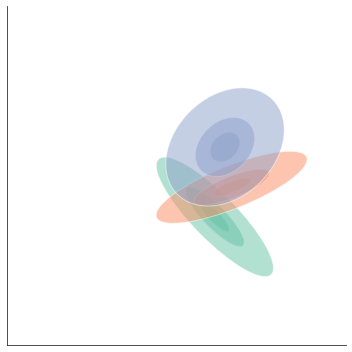

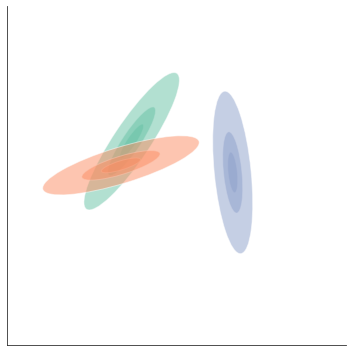

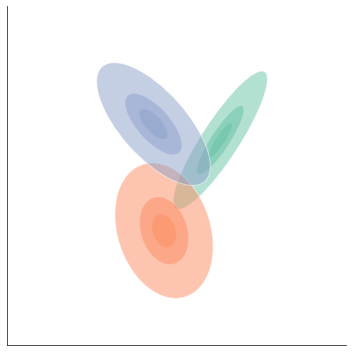

In [74]:
num_networks = 3
n_conditions = 3
seed = 42069
rng = np.random.default_rng(seed)
lims = (-3, 3)
cols = sns.color_palette('Set2', n_conditions)
with sns.axes_style('white'):
    for i in range(num_networks):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        for cond in range(n_conditions):
            mu, C = generate_data(n_conditions, rng)
            plot_ellipses(C[cond], mu[cond], stdevs=(.5, 1., 2.), ax=ax, alpha=.5, facecolor=cols[cond])
        
        ax.axis('square')
        ax.set(xlim=lims, ylim=lims,  xticks=[], yticks=[])
        sns.despine(fig)
        fig.tight_layout()

## Covariance geodesics

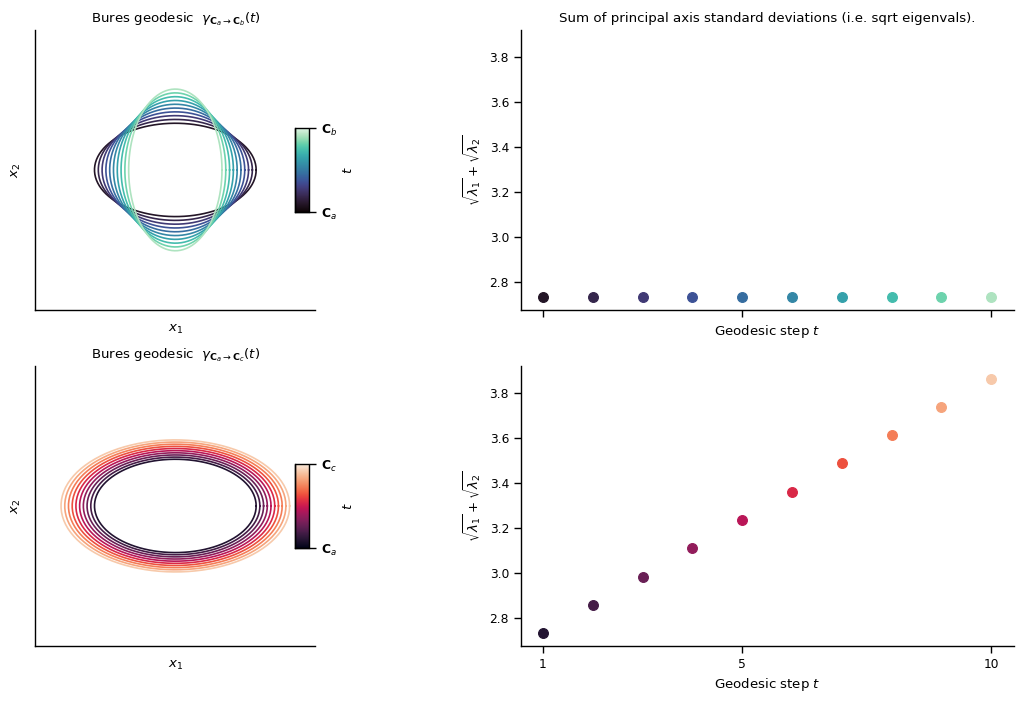

In [17]:
# Bures-Wasserstein geodesic between two covariance matrices
from scipy.linalg import sqrtm

def bures(c1: np.ndarray, c2: np.ndarray) -> float:
    """Compute Bures metric btwn two covs."""
    sqrt_c1 = sqrtm(c1)
    return c1 + c2 - 2 * sqrtm(sqrt_c1 @ c2 @ sqrt_c1)

def bw_geodesic(c1: np.ndarray, c2: np.ndarray, t: float) -> float:
    """Interpolate t between C1 and C2 using Bures-Wasserstein geodesic.
    Thanwerdas and Pennec (2022) https://arxiv.org/abs/2204.09928
    """
    assert 0 <= t <= 1
    sqrt_c1 = sqrtm(c1)
    A = sqrt_c1 @ sqrtm(sqrt_c1 @ c2 @ sqrt_c1) @ np.linalg.inv(sqrt_c1)
    A = .5 * (A + A.T)
    return ((1-t)**2)*c1 + (t**2)*c2 + (2*t*(1-t)) * A

def scatter_cov_ellipse(C: np.ndarray, n_pts: int, ax, **kwargs) -> None:
    """Plot of ellipse with n_pts."""
    L = np.linalg.cholesky(C)
    theta = np.linspace(0, 2*np.pi, n_pts)
    circle = np.stack([np.cos(theta), np.sin(theta)])
    X = L.T@circle
    ax.plot(*X, **kwargs) 

Ca = np.array([[3, 0], 
              [0, 1]])

Cb = np.array([[1, 0], 
               [0, 3]])

Cc = Ca * 2

n_steps = 10
cols_mako = sns.color_palette('mako', n_steps)
cols_rocket = sns.color_palette('rocket', n_steps)
_ = np.arange(n_steps)
fig, ax = plt.subplots(1, 1)
im_m = plt.imshow(_[:, None], cmap='mako')
plt.close(fig)
fig, ax = plt.subplots(1, 1)
im_r = plt.imshow(_[:, None], cmap='rocket')
plt.close(fig)


lims = (-3, 3)
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(2, 2, figsize=(14, 8), dpi=100, sharex='col', sharey='col')
    ax = ax.flatten()
    Ct = [bw_geodesic(Ca, Cb, t) for t in np.linspace(0, 1, n_steps)[1:-1]]
    Ct = [Ca] + Ct + [Cb]
    for i, c in enumerate(Ct):
        scatter_cov_ellipse(c, 100, ax[0], color=cols_mako[i])
        ax[1].scatter(i+1, np.sum(np.sqrt(np.linalg.eigvalsh(c))), s=50, color=cols_mako[i])


    Ct = [bw_geodesic(Ca, Cc, t) for t in np.linspace(0, 1, n_steps)]
    # Ct = [Ca] + Ct + [Cc]
    for i, c in enumerate(Ct):
        scatter_cov_ellipse(c, 100, ax[2], color=cols_rocket[i])
        ax[3].scatter(i+1, np.sum(np.sqrt(np.linalg.eigvalsh(c))), s=50, color=cols_rocket[i])

    ax[0].axis('square')
    ax[0].set(xlim=lims, ylim=lims,  xticks=[], yticks=[], xlabel=r'$x_1$', ylabel=r'$x_2$', 
        title=r'Bures geodesic  $\gamma_{{\bf C}_a \rightarrow {\bf C}_b}(t)$')
    ax[1].set(xlabel=r'Geodesic step $t$', ylabel=r'$\sqrt{\lambda_1} + \sqrt{\lambda_2}$', xticks=(1, n_steps//2, n_steps),
    title='Sum of principal axis standard deviations (i.e. sqrt eigenvals).'
    )

    ax[2].axis('square')
    ax[2].set(xlim=lims, ylim=lims,  xticks=[], yticks=[], xlabel=r'$x_1$', ylabel=r'$x_2$', 
        title=r'Bures geodesic  $\gamma_{{\bf C}_a \rightarrow {\bf C}_c}(t)$')
    ax[3].set(xlabel=r'Geodesic step $t$', ylabel=r'$\sqrt{\lambda_1} + \sqrt{\lambda_2}$', xticks=(1, n_steps//2, n_steps))


    cbaxes = inset_axes(ax[0], width="5%", height="30%", loc='center right')
    cbar = plt.colorbar(im_m, cax=cbaxes, orientation='vertical', ticks=[0, n_steps-1], label=r'$t$')
    cbar.ax.set_yticklabels([r'${\bf C}_a$', r'${\bf C}_b$'])  

    cbaxes = inset_axes(ax[2], width="5%", height="30%", loc='center right')
    cbar = plt.colorbar(im_r, cax=cbaxes, orientation='vertical', ticks=[0, n_steps-1], label=r'$t$')
    cbar.ax.set_yticklabels([r'${\bf C}_a$', r'${\bf C}_c$'])  


    sns.despine()
    # fig.tight_layout()


## Wasserstein between two Gaussians

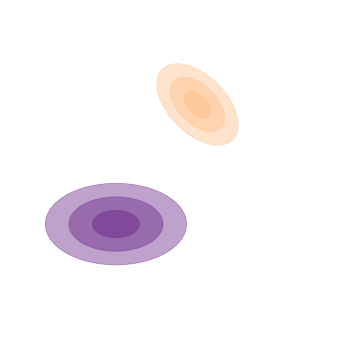

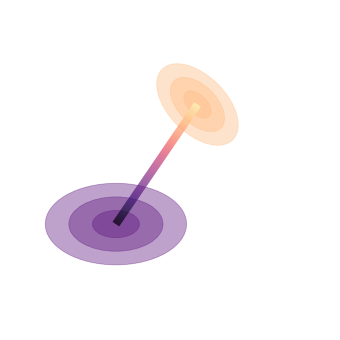

In [18]:
def interpolate_means(mu_a: np.ndarray, mu_b: np.ndarray, n_steps: int) -> np.ndarray:
    """Interpolate between two means."""
    return np.stack((np.linspace(mu_a[0], mu_b[0], n_steps), np.linspace(mu_a[1], mu_b[1], n_steps))).T

n_steps = 10
mu_a, mu_b = np.array([-1, -1]), np.array([.5, 1.2])

mu_t = interpolate_means(mu_a, mu_b, n_steps)

cols_mako = sns.color_palette('magma', n_steps+10)[5:-2]
Cd = rot2d(Ca, np.pi/4)/2
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    plot_ellipses(Ca, mu_t[0], stdevs=(.5,1,1.5), ax=ax, color=cols_mako[0], alpha=0.4, zorder=-1)
    plot_ellipses(Cd, mu_t[-1], stdevs=(.5,1,1.5), ax=ax, color=cols_mako[-1], alpha=0.4, zorder=-1)

    ax.axis('square')
    ax.set(xlim=lims, ylim=lims, xticks=[], yticks=[])
    ax.axis('off')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    plot_ellipses(Ca, mu_t[0], stdevs=(.5,1,1.5), ax=ax, color=cols_mako[0], alpha=0.4, zorder=-1)
    plot_ellipses(Cd, mu_t[-1], stdevs=(.5,1,1.5), ax=ax, color=cols_mako[-1], alpha=0.4, zorder=-1)

    M = 500
    points = interpolate_means(mu_a, mu_b, M).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1) 
    norm = plt.Normalize(0, M)
    lc = LineCollection(segments, cmap='magma', norm=norm, zorder=0)
    lc.set_array(np.arange(M))
    lc.set_linewidth(8)
    line = ax.add_collection(lc)
    ax.axis('square')
    ax.set(xlim=lims, ylim=lims, xticks=[], yticks=[])
    ax.axis('off')
    sns.despine()

### Make a gif of geodesic interpolation btwn two Gaussians

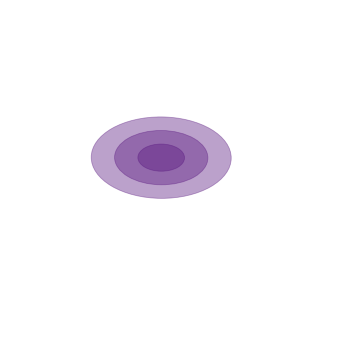

In [15]:

n_steps = 50
cols_mako = sns.color_palette('magma', n_steps+n_steps)[n_steps//2:-n_steps//5]
Ct = [bw_geodesic(Ca, Cd, t) for t in np.linspace(0, 1, n_steps)[1:-1]]
C_anim = [Ca] + Ct + [Cd] 

with sns.plotting_context('paper'):
    # draw animation and save as gif
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    def animate(i: int) -> None:
        """Draw ellipse, clear pane, draw next ellipse, etc. then save as gif."""
        ax.clear()
        plot_ellipses(C_anim[i], mu_t[len(mu_t)//2], stdevs=(.5,1,1.5), ax=ax, color=cols_mako[i], alpha=0.4, zorder=-1)
        ax.axis('square')
        ax.set(xlim=lims, ylim=lims, xticks=[], yticks=[])
        sns.despine(bottom=True, left=True)    

    T = list(np.arange(len(C_anim)))
    T = T + T[1:-1][::-1]
    anim = FuncAnimation(fig, animate, frames=T, interval=100)
    anim.save('bw_geodesic.gif', dpi=80, writer='imagemagick')

## Alignment of latent space

58.5114143864278


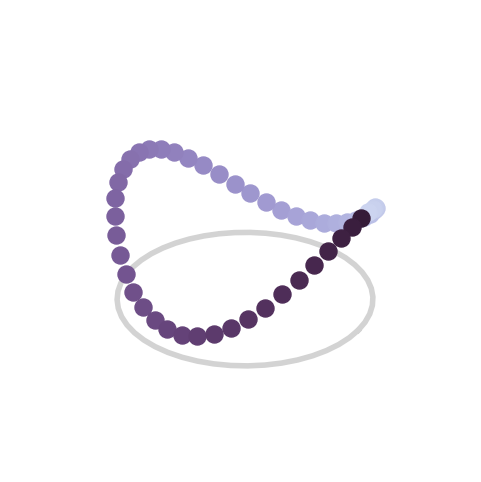

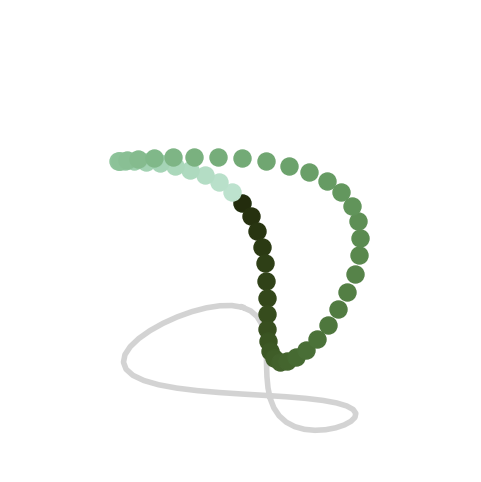

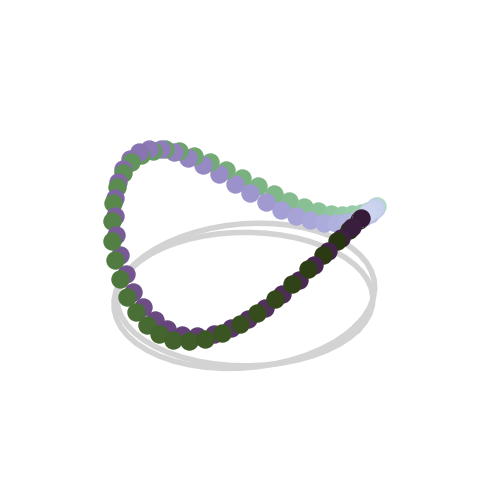

In [3]:
# points on a circle
n = 50
theta = np.linspace(0, 2*np.pi, n)
x = np.cos(theta)
y = np.sin(theta)
z = x**2  

rng = np.random.default_rng(42069)
X0 = np.stack((x, y, z)).T
X0 = X0 - X0.mean(axis=0)

Q, _ = np.linalg.qr(rng.standard_normal((3, 3)))
X1 = X0.copy()
X1 *= rng.uniform(0.8, 1.2, size=(1, 3))
X1 = X1 @ Q


def plot3d(X, cols, ax=None):
    """Plot 3d points."""
    lims = (-1.1, 1.1)
    zlims = (-1.1, 1.0)
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

    # plot shadow
    ax.plot(X[:,0], X[:,1], np.min(X[:,2])*1.5, color='lightgrey', lw=4, zorder=-1)

    for i in range(n):
        ax.scatter(*X[i], color=cols[i], s=150, zorder=0) 

    ax.set(xlim=lims, ylim=lims, zlim=zlims, xticks=[], yticks=[], zticks=[])
    ax.axis('off')

# plot 3d 
cols0 = sns.cubehelix_palette(start=.5, rot=-.25, n_colors=n)
cols1 = sns.cubehelix_palette(start=1.5, rot=.25, n_colors=n)


plot3d(X0, cols0)
plot3d(X1, cols1)

# scipy procrustes align X1 to X0
from scipy.linalg import orthogonal_procrustes
R, dist = orthogonal_procrustes(X1, X0,)
print(dist)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
plot3d(X1 @ R, cols1, ax)
plot3d(X0, cols0, ax)